Хмелёв Алексей, группа MADE-DS-22

# Продвинутое машинное обучение. Домашнее задание 1

Это задание связано с анализом конкретного датасета, в котором, надеюсь, понадобится то, чему мы с вами до сих пор научились. Датасет давайте возьмем довольно релевантный реальной жизни; он доступен по следующей ссылке:

https://ourworldindata.org/coronavirus-source-data

1. Скачайте данные в формате csv, выберите из таблицы данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases); для упрощения обработки можно заменить в столбце new_cases все нули на единицы. Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from datetime import datetime
from scipy.stats import multivariate_normal

figsize = (20, 10)
legend_size = 14
START_DAY = datetime(2020, 3, 3)
NUM_DAYS_FOR_TRAIN = 50

In [2]:
url = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'
covid_df = pd.read_csv(url, parse_dates=['date'])

In [3]:
covid_df

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160232,ZWE,Africa,Zimbabwe,2022-02-03,230170.0,158.0,153.429,5357.0,5.0,4.714,15250.954,10.469,10.166,354.952,0.331,0.312,0.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1994516.0,132.156,NaN,22075.0,1.463,0.0070,143.9,tests performed,7600946.0,4286198.0,3314748.0,NaN,7022.0,8296.0,50.36,28.40,21.96,NaN,550.0,4160.0,0.028,NaN,15092171.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
160233,ZWE,Africa,Zimbabwe,2022-02-04,230170.0,0.0,119.571,5357.0,0.0,3.429,15250.954,0.000,7.923,354.952,0.000,0.227,0.44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21994.0,1.457,0.0054,183.9,tests performed,7611929.0,4292012.0,3319917.0,NaN,10983.0,8188.0,50.44,28.44,22.00

In [4]:
covid_df = covid_df[covid_df.location == 'Russia'].reset_index()[['date', 'total_cases', 'new_cases']]
covid_df

,date,total_cases,new_cases
0,2020-01-31,2.0,2.0
1,2020-02-01,2.0,0.0
2,2020-02-02,2.0,0.0
3,2020-02-03,2.0,0.0
4,2020-02-04,2.0,0.0
...,...,...,...
734,2022-02-03,12090707.0,154643.0
735,2022-02-04,12257664.0,166957.0
736,2022-02-05,12433643.0,175979.0
737,2022-02-06,12612259.0,178616.0


In [5]:
covid_df = covid_df[covid_df.date >= START_DAY].reset_index(drop=True)
covid_df

,date,total_cases,new_cases
0,2020-03-03,3.0,0.0
1,2020-03-04,3.0,0.0
2,2020-03-05,4.0,1.0
3,2020-03-06,13.0,9.0
4,2020-03-07,13.0,0.0
...,...,...,...
702,2022-02-03,12090707.0,154643.0
703,2022-02-04,12257664.0,166957.0
704,2022-02-05,12433643.0,175979.0
705,2022-02-06,12612259.0,178616.0


In [6]:
covid_df.loc[covid_df.total_cases == 0, 'total_cases'] = 1
covid_df.loc[covid_df.new_cases == 0, 'new_cases'] = 1

In [7]:
covid_df

,date,total_cases,new_cases
0,2020-03-03,3.0,1.0
1,2020-03-04,3.0,1.0
2,2020-03-05,4.0,1.0
3,2020-03-06,13.0,9.0
4,2020-03-07,13.0,1.0
...,...,...,...
702,2022-02-03,12090707.0,154643.0
703,2022-02-04,12257664.0,166957.0
704,2022-02-05,12433643.0,175979.0
705,2022-02-06,12612259.0,178616.0


In [8]:
LEN_DATASET = len(covid_df)
covid_df['num_day'] = np.arange(LEN_DATASET)

In [9]:
train_df = covid_df.iloc[:NUM_DAYS_FOR_TRAIN]
test_df = covid_df.iloc[NUM_DAYS_FOR_TRAIN:]

In [10]:
train_df

,date,total_cases,new_cases,num_day
0,2020-03-03,3.0,1.0,0
1,2020-03-04,3.0,1.0,1
2,2020-03-05,4.0,1.0,2
3,2020-03-06,13.0,9.0,3
4,2020-03-07,13.0,1.0,4
5,2020-03-08,17.0,4.0,5
6,2020-03-09,17.0,1.0,6
7,2020-03-10,20.0,3.0,7
8,2020-03-11,20.0,1.0,8
9,2020-03-12,28.0,8.0,9


In [11]:
test_df

,date,total_cases,new_cases,num_day
50,2020-04-22,57999.0,5236.0,50
51,2020-04-23,62773.0,4774.0,51
52,2020-04-24,68622.0,5849.0,52
53,2020-04-25,74588.0,5966.0,53
54,2020-04-26,80949.0,6361.0,54
...,...,...,...,...
702,2022-02-03,12090707.0,154643.0,702
703,2022-02-04,12257664.0,166957.0,703
704,2022-02-05,12433643.0,175979.0,704
705,2022-02-06,12612259.0,178616.0,705


2. Постройте графики целевых переменных. Вы увидите, что число заболевших растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к снаряду давайте это и используем.

  а. Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: _y ~ exp(линейная функция от x)_, где x - номер текущего дня

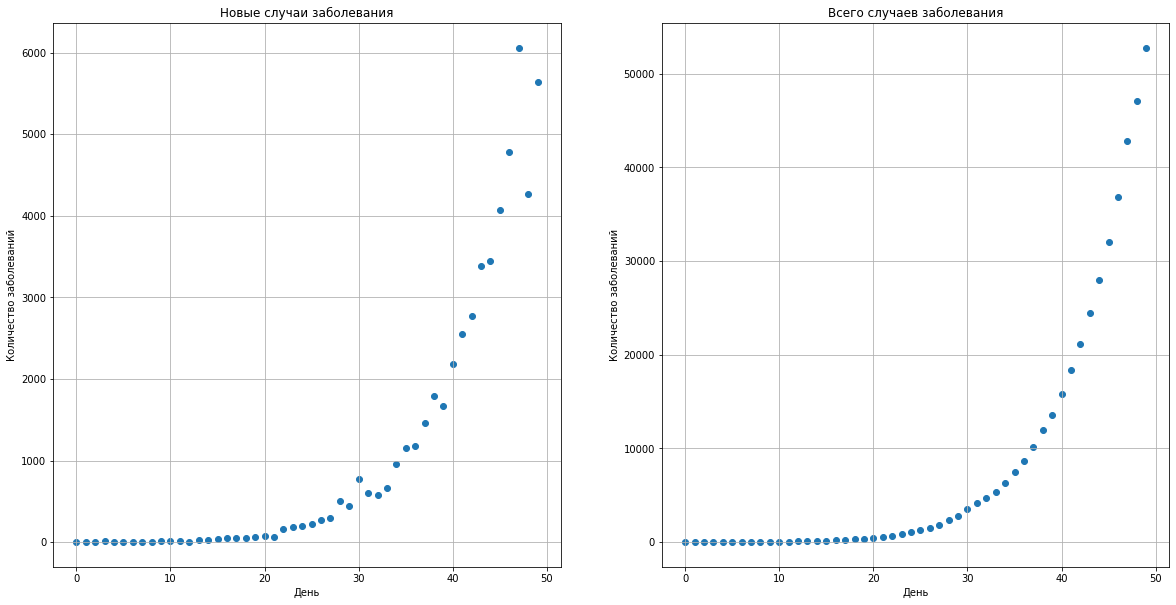

In [12]:
plt.figure(figsize=figsize)

plt.subplot(121)
plt.scatter(train_df['num_day'], train_df['new_cases'])
plt.title('Новые случаи заболевания')
plt.xlabel('День')
plt.ylabel('Количество заболеваний')
plt.grid()

plt.subplot(122)
plt.scatter(train_df['num_day'], train_df['total_cases'])
plt.title('Всего случаев заболевания')
plt.xlabel('День')
plt.ylabel('Количество заболеваний')
plt.grid()

plt.show()

Посмотрим на графики в лог-шкале

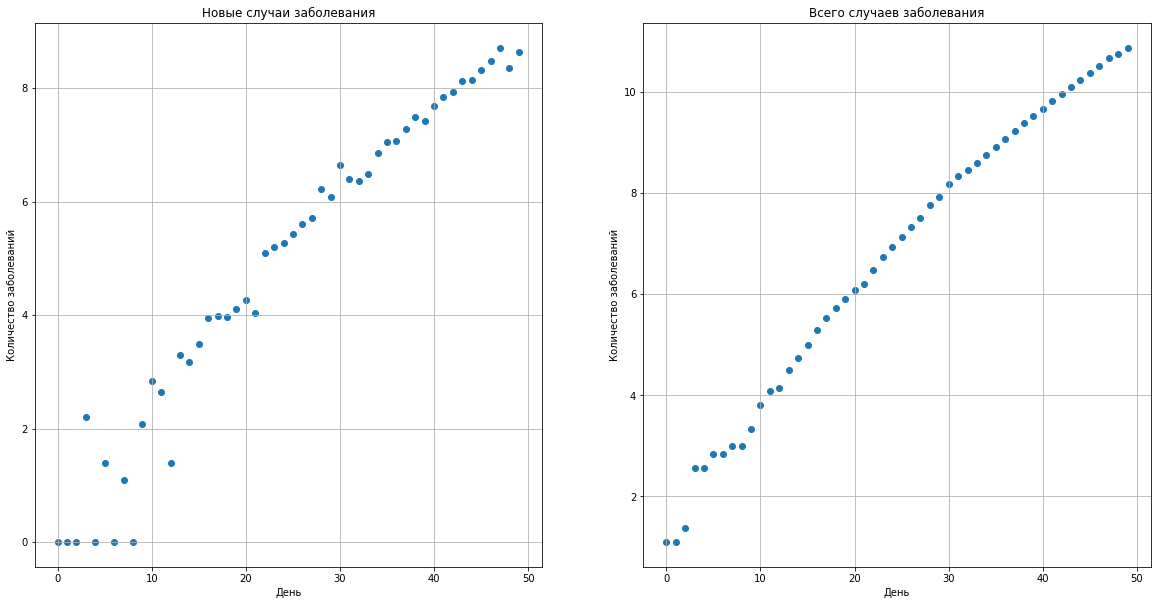

In [13]:
plt.figure(figsize=figsize)

plt.subplot(121)
plt.scatter(train_df['num_day'], np.log(train_df['new_cases']))
plt.title('Новые случаи заболевания')
plt.xlabel('День')
plt.ylabel('Количество заболеваний')
plt.grid()

plt.subplot(122)
plt.scatter(train_df['num_day'], np.log(train_df['total_cases']))
plt.title('Всего случаев заболевания')
plt.xlabel('День')
plt.ylabel('Количество заболеваний')
plt.grid()

plt.show()

Для того, чтобы получить экспоненциальную зависимость, для обучения вместо $y$ возьмём $ln(y)$, тем самым при потенциировании как раз получим желаемую модель

In [14]:
exp_model = LinearRegression()
exp_model.fit(train_df['num_day'].values.reshape(-1, 1), np.log(train_df['total_cases']))

prediction_about_we_will_die = np.exp(exp_model.predict(covid_df['num_day'].values.reshape(-1, 1)))

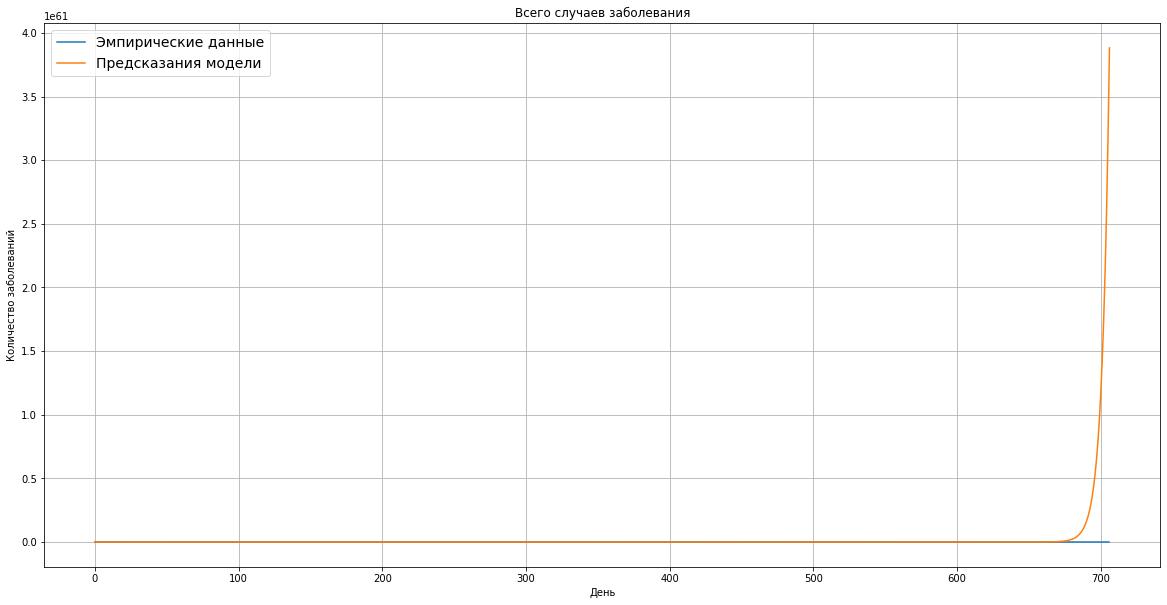

In [15]:
plt.figure(figsize=figsize)

plt.plot(covid_df['num_day'], covid_df['total_cases'], label='Эмпирические данные')
plt.plot(covid_df['num_day'], prediction_about_we_will_die, label='Предсказания модели')
plt.title('Всего случаев заболевания')
plt.xlabel('День')
plt.ylabel('Количество заболеваний')
plt.legend(fontsize=legend_size)
plt.grid()

plt.show()

И так видно, что функция плохая, но чтобы график был хоть сколько-либо читаемым, построим график только для данных за первый год

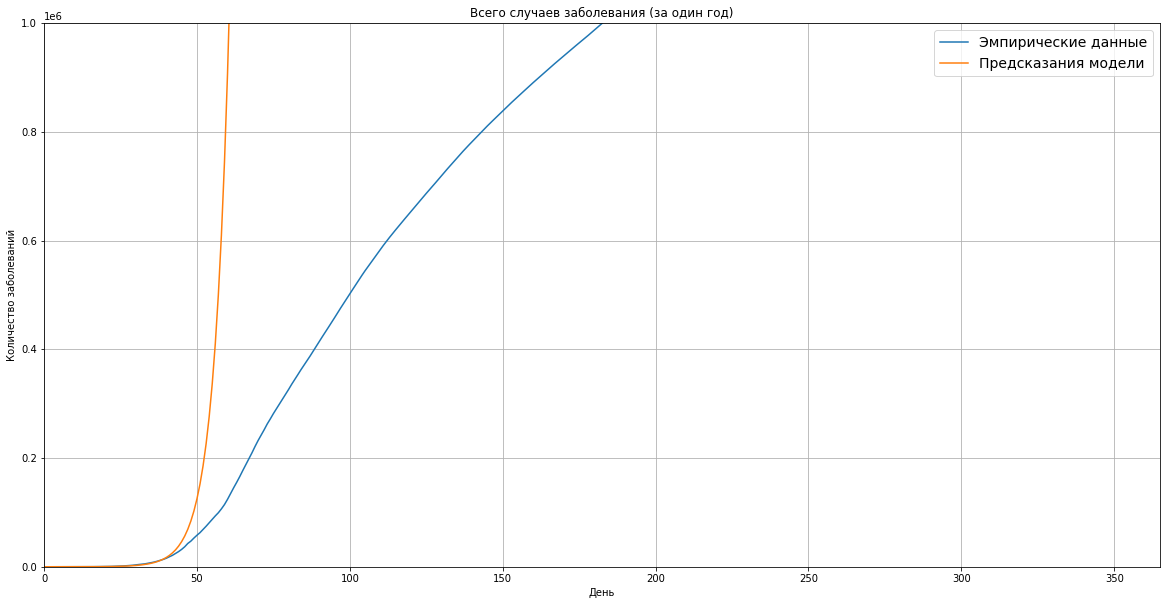

In [16]:
plt.figure(figsize=figsize)

plt.plot(covid_df['num_day'], covid_df['total_cases'], label='Эмпирические данные')
plt.plot(covid_df['num_day'], prediction_about_we_will_die, label='Предсказания модели')
plt.title('Всего случаев заболевания (за один год)')
plt.xlabel('День')
plt.ylabel('Количество заболеваний')
plt.xlim(0, 365)
plt.ylim(0, 1e6)
plt.legend(fontsize=legend_size)
plt.grid()

plt.show()

b. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).

In [17]:
prediction = exp_model.predict(train_df['num_day'].values.reshape(-1, 1))
sigma_noise = np.var(np.log(train_df['total_cases']) - prediction)
sigma_noise

0.12183046154391233

In [18]:
def bayesian_update(mu, sigma, X, y, sigma_noise):
    sigma_n = np.linalg.inv(np.linalg.inv(sigma) + (1 / (sigma_noise ** 2)) * X.T @ X)
    mu_n = sigma_n @ (np.linalg.inv(sigma) @ mu.T + (1 / (sigma_noise ** 2)) * X.T @ y)
    return mu_n, sigma_n

In [19]:
X = np.column_stack([np.ones(NUM_DAYS_FOR_TRAIN), train_df['num_day']])

alpha = 0.1

mu, sigma = bayesian_update(mu=np.zeros(2),
                            sigma=alpha * np.eye(2),
                            X=X,
                            y=np.log(train_df['total_cases']).values,
                            sigma_noise=sigma_noise)

print(f'mu = \n {mu}')
print(f'sigma = \n {sigma}')

mu = 
 [1.80006111 0.19891673]
sigma = 
 [[ 1.13934610e-03 -3.45255127e-05]
 [-3.45255127e-05  1.41338787e-06]]


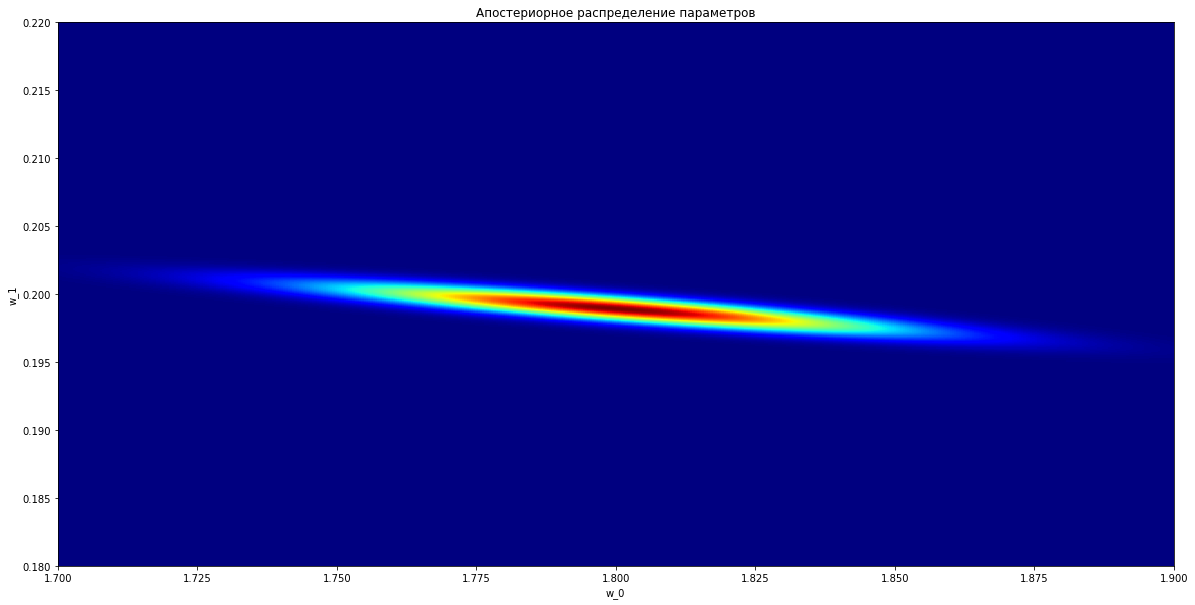

In [20]:
w_0 = np.linspace(1.7, 1.9, 500)
w_1 = np.linspace(0.18, 0.22, 500)
w_0, w_1 = np.meshgrid(w_0, w_1)
grid = np.empty((*w_0.shape, 2))
grid[..., 0] = w_0
grid[..., 1] = w_1

p = multivariate_normal.pdf(grid, mu, sigma)

plt.figure(figsize=figsize)
plt.pcolormesh(w_0, w_1, p, cmap=plt.cm.jet)
plt.xlabel('w_0')
plt.ylabel('w_1')
plt.title('Апостериорное распределение параметров')
plt.show()

  c. Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмперически, исходя из данных сэмплирования)

In [21]:
FIRST_MAY = (datetime(2020, 5, 1) - START_DAY).days
FIRST_JUNE = (datetime(2020, 6, 1) - START_DAY).days
FIRST_SEPTEMBER = (datetime(2020, 9, 1) - START_DAY).days
DATES_FOR_PREDS = [FIRST_MAY, FIRST_JUNE, FIRST_SEPTEMBER]
NAMES_DATES = ['1 мая', '1 июня', '1 сентября']
NUM_PREDS = len(DATES_FOR_PREDS)

In [22]:
n = 100
w = np.random.multivariate_normal(mu, sigma, n)

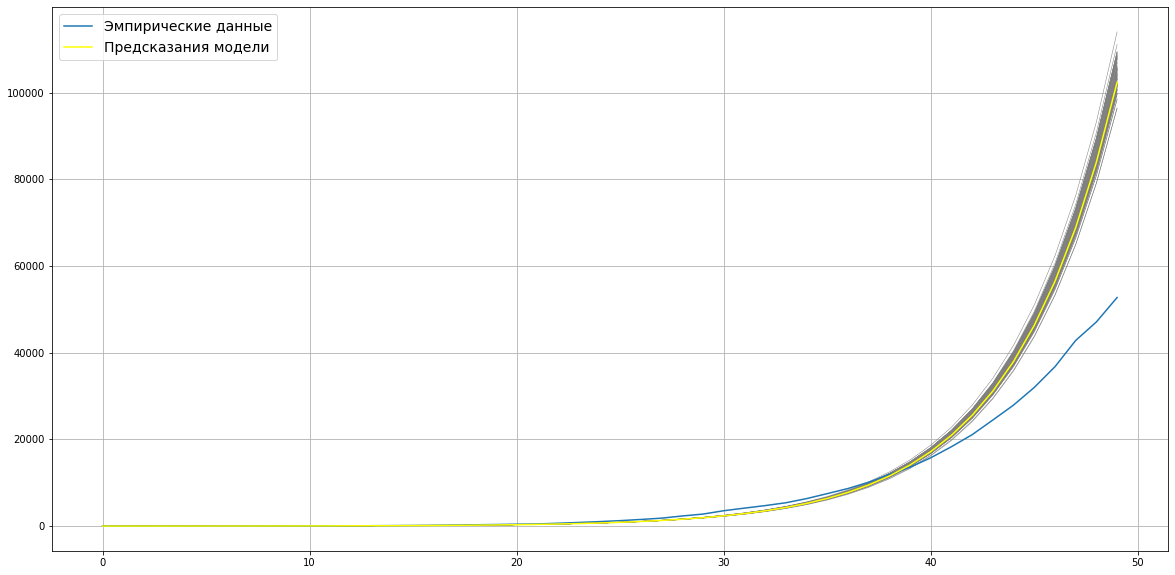

In [23]:
plt.figure(figsize=figsize)

for i in range(n):
    plt.plot(train_df['num_day'], np.exp(X @ w[i]), color='0.5', linewidth="0.5")

plt.plot(train_df['num_day'], train_df['total_cases'], label='Эмпирические данные')
plt.plot(train_df['num_day'], np.exp(prediction), label='Предсказания модели', color='yellow')

plt.legend(fontsize=legend_size)
plt.grid()
plt.show()

In [24]:
X = np.column_stack([np.ones(NUM_PREDS), DATES_FOR_PREDS])

prediction = np.exp(w @ X.T)

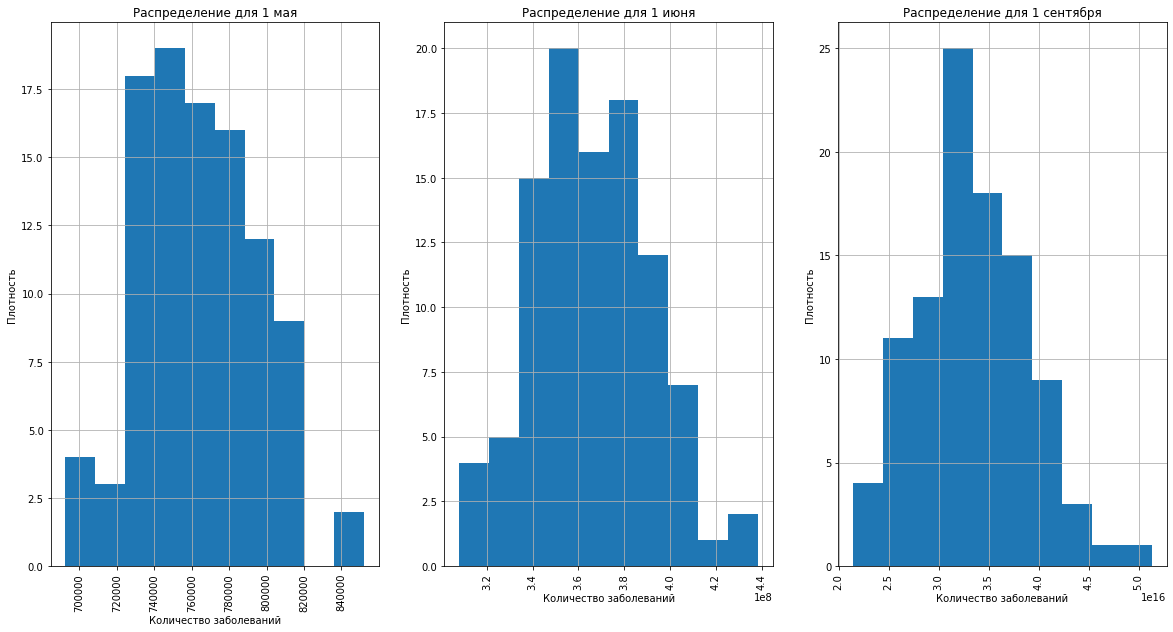

In [25]:
plt.figure(figsize=figsize)

for i in range(NUM_PREDS):
    plt.subplot(1, NUM_PREDS, i + 1)
    plt.hist(prediction[:, i])
    plt.title(f'Распределение для {NAMES_DATES[i]}')
    plt.xlabel('Количество заболеваний')
    plt.ylabel('Плотность')
    plt.xticks(rotation=90)
    plt.grid()

plt.show()

In [26]:
for i in range(NUM_PREDS):
    print(f'{NAMES_DATES[i]}: ')
    mean = np.mean(prediction[:, i])
    median = np.quantile(prediction[:, i], 0.5)
    true_value = covid_df.loc[covid_df.num_day == DATES_FOR_PREDS[i], 'total_cases'].iloc[0]
    print(f'Среднее {mean:.0f}, медиана {median:.0f}, истинное значение {true_value}')

1 мая: 
Среднее 763861, медиана 762557, истинное значение 114431.0
1 июня: 
Среднее 366651974, медиана 365890151, истинное значение 414328.0
1 сентября: 
Среднее 33422695955624208, медиана 32705435901533688, истинное значение 997072.0


3. Предсказания экспоненциальной модели навернякаполучились грустными. Но это, конечно, чересчур пессимистично - экспоненциальный рост в природе никак не может продолжаться вечно. Кривая общего числа заболевших во время эпидемии в реальности имеет сигмоидальный вид: после начальной фазы экспоненциального роста неизбежно происходит насыщение. В качестве конкретной формы такой сигмоиды давайте возьмем форму функции распределения для гауссиана:
$$ \Phi(x) = \frac{1}{\sqrt{2\pi}} \int\limits_{-\infty}^x e^{-t^2/2} dt $$
Естественно, в нашем случае сигмоида стремится не к единице, т.е. константа перед интегралом может быть произвольной (и её можно внести в экспоненту), а в экспоненте под интегралом может быть произвольная квадратичная функция от t.

  a. Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии

Уравнение сигмоиды можно представить в следующем виде:
$$ \Phi(x) = \int\limits_{0}^x \exp(at^2 + bt + c) dt $$
Коэффициент перед интегралом можно не ставить, т.к. за эту константу отвечает параметр $c$.
Значение номера дня у нас положительно, поэтому интегрировать можно с нуля.
Также значения номера дня у нас дискретные (с шагом 1). Следовательно, модель можно представить в виде:
$$ y_i - y_{i - 1} = \exp(ax^2 + bx + c) $$
Или же
$$ \ln (y_i - y_{i-1}) = ax^2 + bx + c $$
Значит необходимо расширить датасет признаком $x^2$ и в качестве целевой переменной использовать логарифм разностей (о, а разности же у нас как раз хранятся в new_cases)

 b. Обучите эти параметры на датасете случаев коронавируса в России. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели.

In [27]:
sigmoid_model = LinearRegression()
X = np.column_stack([train_df['num_day'], train_df['num_day'] ** 2])
sigmoid_model.fit(X, np.log(train_df['new_cases'].values))

X_test = np.column_stack([covid_df['num_day'], covid_df['num_day'] ** 2])
prediction_about_we_will_live = np.exp(sigmoid_model.predict(X_test)).cumsum()

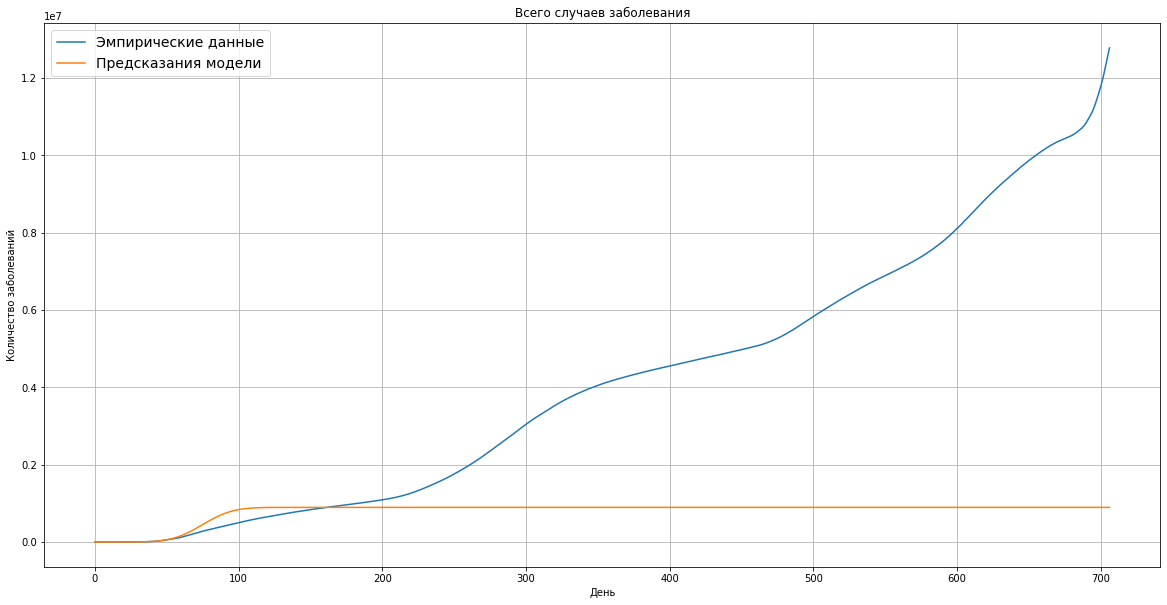

In [28]:
plt.figure(figsize=figsize)

plt.plot(covid_df['num_day'], covid_df['total_cases'], label='Эмпирические данные')
plt.plot(covid_df['num_day'], prediction_about_we_will_live, label='Предсказания модели')
plt.title('Всего случаев заболевания')
plt.xlabel('День')
plt.ylabel('Количество заболеваний')
plt.legend(fontsize=legend_size)
plt.grid()

plt.show()

Все-таки такую сложную зависимость обычной сигмоидой уловить врядли выйдет, но давайте также посмотрим только первый год, по сравнению с экспонентой качество должно быть лучше

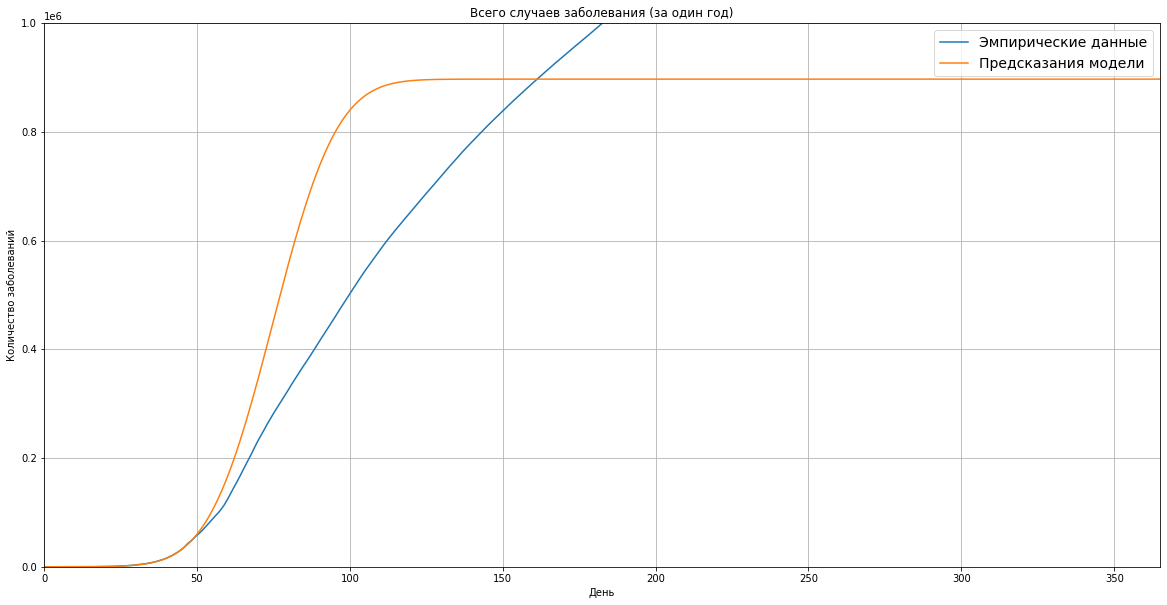

In [29]:
plt.figure(figsize=figsize)

plt.plot(covid_df['num_day'], covid_df['total_cases'], label='Эмпирические данные')
plt.plot(covid_df['num_day'], prediction_about_we_will_live, label='Предсказания модели')
plt.title('Всего случаев заболевания (за один год)')
plt.xlabel('День')
plt.ylabel('Количество заболеваний')
plt.xlim(0, 365)
plt.ylim(0, 1e6)
plt.legend(fontsize=legend_size)
plt.grid()

plt.show()

Как минимум на первых 50 днях все гладко, если бы тренировочная выборка состояла хотя бы из примерно первых 70 дней, общий результат был бы получше

In [30]:
prediction = sigmoid_model.predict(X)
sigma_noise = np.var(np.log(train_df['new_cases']).values - prediction)

X = np.column_stack([np.ones(NUM_DAYS_FOR_TRAIN), X])

alpha = 10

mu, sigma = bayesian_update(mu=np.zeros(3),
                            sigma=alpha * np.eye(3),
                            X=X,
                            y=np.log(train_df['new_cases']).values,
                            sigma_noise=sigma_noise)

print(f'mu = \n {mu}')
print(f'sigma = \n {sigma}')

mu = 
 [-0.39619186  0.27559001 -0.00182923]
sigma = 
 [[ 9.51491116e-03 -7.68749240e-04  1.29418917e-05]
 [-7.68749240e-04  8.47844579e-05 -1.61828317e-06]
 [ 1.29418917e-05 -1.61828317e-06  3.30297637e-08]]


  c. Посэмплируйте много разных сигмоид из апостериорного распределения, постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев коронавируса в России? Постройте эмпирическое предсказательное распределение, нарисуйте графики. Каков ваш прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? В оптимистичном сценарии (10-й процентиль)?

In [31]:
n = 100
w = np.random.multivariate_normal(mu, sigma, n)

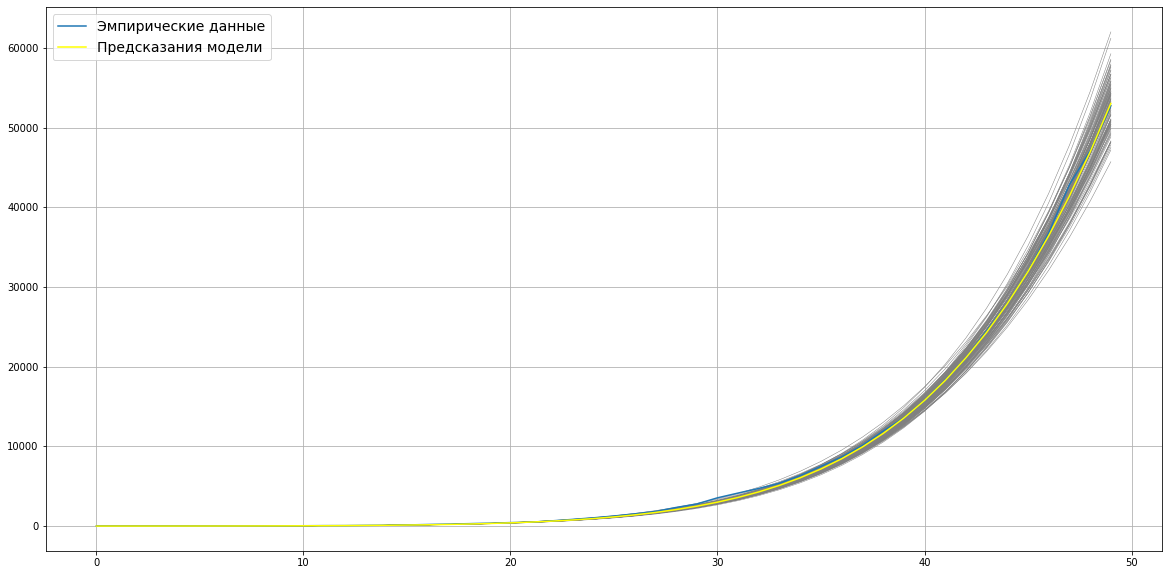

In [32]:
plt.figure(figsize=figsize)

for i in range(n):
    plt.plot(train_df['num_day'], np.exp(X @ w[i]).cumsum(), color='0.5', linewidth="0.5")

plt.plot(train_df['num_day'], train_df['total_cases'], label='Эмпирические данные')
plt.plot(train_df['num_day'], np.exp(prediction).cumsum(), label='Предсказания модели', color='yellow')

plt.legend(fontsize=legend_size)
plt.grid()
plt.show()

In [33]:
x = np.arange(max(DATES_FOR_PREDS) + 1)

X = np.column_stack([np.ones(len(x)), x, x ** 2])

prediction = np.exp(w @ X.T).cumsum(1)

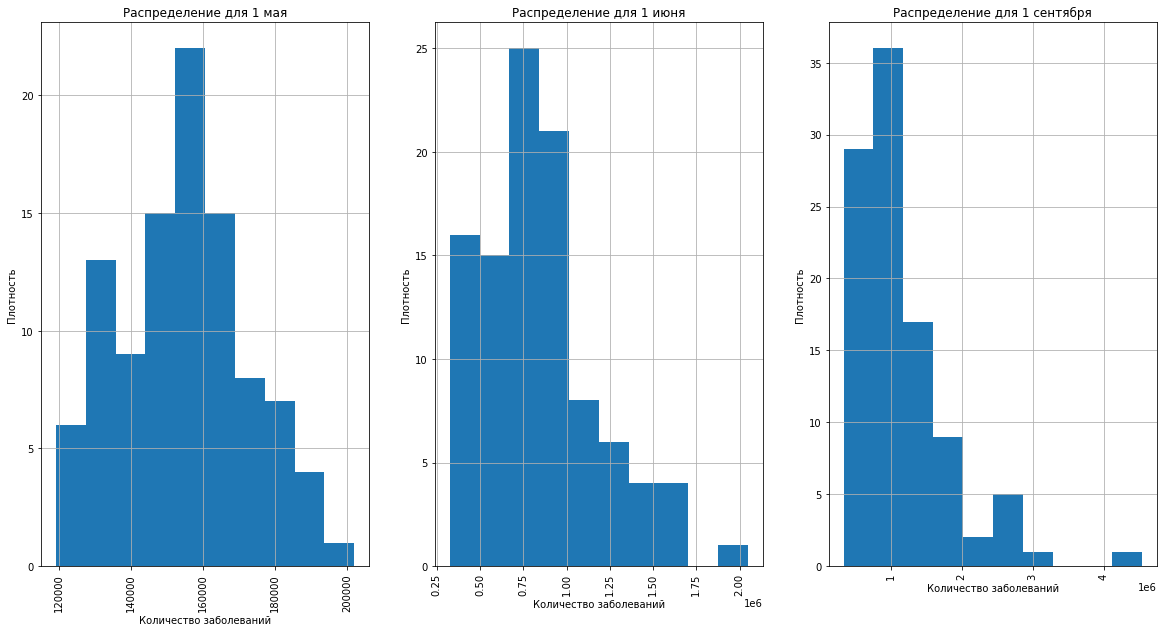

In [34]:
plt.figure(figsize=figsize)

for i in range(NUM_PREDS):
    plt.subplot(1, NUM_PREDS, i + 1)
    plt.hist(prediction[:, DATES_FOR_PREDS[i]])
    plt.title(f'Распределение для {NAMES_DATES[i]}')
    plt.xlabel('Количество заболеваний')
    plt.ylabel('Плотность')
    plt.xticks(rotation=90)
    plt.grid()

plt.show()

In [35]:
for i in range(NUM_PREDS):
    print(f'{NAMES_DATES[i]}: ')
    mean = np.mean(prediction[:, DATES_FOR_PREDS[i]])
    median = np.quantile(prediction[:, DATES_FOR_PREDS[i]], 0.5)
    true_value = covid_df.loc[covid_df.num_day == DATES_FOR_PREDS[i], 'total_cases'].iloc[0]
    print(f'Среднее {mean:.0f}, медиана {median:.0f}, истинное значение {true_value}')
    print(f'Пессиместичный сценарий: {np.quantile(prediction[:, DATES_FOR_PREDS[i]], 0.9):.0f}')
    print(f'Оптимистичный сценарий: {np.quantile(prediction[:, DATES_FOR_PREDS[i]], 0.1):.0f}')

1 мая: 
Среднее 154368, медиана 154660, истинное значение 114431.0
Пессиместичный сценарий: 178435
Оптимистичный сценарий: 129457
1 июня: 
Среднее 845587, медиана 793977, истинное значение 414328.0
Пессиместичный сценарий: 1286462
Оптимистичный сценарий: 478126
1 сентября: 
Среднее 1154168, медиана 977542, истинное значение 997072.0
Пессиместичный сценарий: 1948593
Оптимистичный сценарий: 527527


4. _Бонус:_ проведите такой же анализ для других стран (здесь придётся руками подобрать дни начала моделирования - коронавирус приходил в разные страны в разное время). Насколько разные параметры получаются? Можно ли разделить страны на кластеры (хотя бы чисто визуально) в зависимости от этих параметров?

5. _[Эта часть задания не оценивается, здесь нет правильных и неправильных ответов, но буду рад узнать, что вы думаете]_. Что вы поняли из этого упражнения? Что можно сказать про коронавирус по итогам такого моделирования? Как принять решение, например, о том, нужно ли вводить карантин?